In [ ]:
import pandas as pd
import numpy as np
import requests
import pyodbc
from io import StringIO

import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

In [44]:
# Configuración de los parámetros de conexión
server = 'localhost\\SQLEXPRESS'  # O el punto '.' que usaste en SSMS
database = 'BD_REM'

# Cadena de conexión usando Autenticación de Windows (Trusted_Connection)
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'Trusted_Connection=yes;'
)


In [45]:
query = "select * from dbo.estaciones_full;"
conn = pyodbc.connect(conn_str)
raw_data = pd.read_sql(query, conn)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_9720\341712462.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql(query, conn)


In [46]:
query = "select * from dbo.coordenadas_estaciones;"
conn = pyodbc.connect(conn_str)
coor = pd.read_sql(query, conn)
coor.drop(["tx_id"], axis=1, inplace=True)

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_9720\2772575436.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  coor = pd.read_sql(query, conn)


In [47]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31809 entries, 0 to 31808
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   tx_id              31809 non-null  int64         
 1   codigo_estacion    31809 non-null  object        
 2   fecha_observacion  31809 non-null  datetime64[ns]
 3   sensor_pre         31809 non-null  object        
 4   sensor_vel         31809 non-null  object        
 5   sensor_dir         31809 non-null  object        
 6   sensor_tem         31809 non-null  object        
 7   presion            31809 non-null  float64       
 8   velocidad          31809 non-null  float64       
 9   direccion          31809 non-null  float64       
 10  temperatura        31809 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 2.7+ MB


# explo

## coordenadas

In [48]:
coor.apply(lambda df: f"{df["codigo_estacion"]}: ( {df["latitud"]} , {df["longitud"]} )", axis=1)

0     0035085080: ( 5.099 , -73.436 )
1     0035080050: ( 5.096 , -73.053 )
2     0024015300: ( 5.643 , -73.518 )
3     0024035503: ( 5.818 , -72.844 )
4     0035075070: ( 5.216 , -73.347 )
5     0024035430: ( 5.746 , -73.116 )
6     3507500046: ( 4.976 , -73.483 )
7     2403500083: ( 5.524 , -73.077 )
8     2401500086: ( 5.554 , -73.355 )
9     2311500200: ( 6.221 , -74.562 )
10    0024015220: ( 5.509 , -73.496 )
11    0023125140: ( 5.521 , -74.182 )
12    0024035360: ( 5.985 , -72.997 )
13    0023125080: ( 5.662 , -74.185 )
14    3507500133: ( 5.442 , -73.552 )
15    0024035370: ( 6.507 , -72.453 )
16    0035215030: ( 5.721 , -72.488 )
17    0024035340: ( 5.677 , -72.968 )
18     0035085060: ( 5.295 , -73.17 )
19    0024030140: ( 5.513 , -73.244 )
20    0035075040: ( 4.974 , -73.317 )
21    0024025030: ( 5.967 , -73.162 )
22    0035235010: ( 6.012 , -72.529 )
23    0035085070: ( 4.841 , -73.257 )
24    0035195060: ( 5.524 , -72.791 )
25    0023125100: ( 5.515 , -73.943 )
26    240350

## registro fechas

In [49]:
df = raw_data.copy()
df.drop("tx_id", axis=1, inplace=True)

In [50]:
print(df.shape)
print("-"*50)
cols = ["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"]
for col in cols:
    print(df[col].value_counts())
    col_0 = df[col].value_counts().index[0]
    df = df[df[col] == col_0].copy()
    print("-"*50)
print(df.shape)

(31809, 10)
--------------------------------------------------
sensor_pre
0255    21741
0258    10068
Name: count, dtype: int64
--------------------------------------------------
sensor_vel
0103    20297
0111     1444
Name: count, dtype: int64
--------------------------------------------------
sensor_dir
0104    20297
Name: count, dtype: int64
--------------------------------------------------
sensor_tem
0068    19575
0071      722
Name: count, dtype: int64
--------------------------------------------------
(19575, 10)


In [51]:
estaciones = df["codigo_estacion"].unique()

In [52]:
# df = df.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)
df = df.sort_values(["fecha_observacion", "codigo_estacion"]).reset_index(drop=True)

In [53]:
df["fecha_observacion"].diff().unique()

<TimedeltaArray>
[NaT, '0 days 00:00:00', '0 days 01:00:00']
Length: 3, dtype: timedelta64[ns]

In [54]:
fecha_minima = pd.to_datetime("2025-12-15")
df = df[df["fecha_observacion"] >= fecha_minima]

In [55]:
estaciones_ok = list()
n = 1
for estacion in estaciones:
    min_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].min()
    max_date = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].max()
    diff_temp = df.loc[df["codigo_estacion"] == estacion, "fecha_observacion"].diff().unique()
    rows_temp = df.loc[df["codigo_estacion"] == estacion].shape[0]
    # if len(diff_temp) == 2: 
    # if rows_temp == 744 and not estacion in ["0024035250", "0024035360"]:
    # if rows_temp == 744:
    # if rows_temp == 408:
    # if min_date <= pd.to_datetime("2025-12-14") and len(diff_temp) == 2:
    if rows_temp == 408 and not estacion in ["0024035250"]:
        print(n , estacion)
        estaciones_ok.append(estacion)
        for diff in diff_temp: print(">", diff)
        print("cantidad de registros: ", rows_temp)
        print("fecha min: ", min_date)
        print("fecha max: ", max_date)
        print("-"*50)
        n += 1

1 0024015300
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
2 0024030140
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
3 2401500086
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
4 0035085080
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
5 0024035360
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fecha max:  2025-12-31 23:00:00
--------------------------------------------------
6 0035075070
> NaT
> 0 days 01:00:00
cantidad de registros:  408
fecha min:  2025-12-15 00:00:00
fec

In [56]:
coor[coor["codigo_estacion"].isin(estaciones_ok)].apply(lambda df: f"{df["codigo_estacion"]}: ( {df["latitud"]} , {df["longitud"]} )", axis=1)

0     0035085080: ( 5.099 , -73.436 )
2     0024015300: ( 5.643 , -73.518 )
4     0035075070: ( 5.216 , -73.347 )
6     3507500046: ( 4.976 , -73.483 )
8     2401500086: ( 5.554 , -73.355 )
12    0024035360: ( 5.985 , -72.997 )
19    0024030140: ( 5.513 , -73.244 )
21    0024025030: ( 5.967 , -73.162 )
dtype: object

In [57]:
print(f"rows: {df.shape[0]:,}")
wsdata = df.loc[df["codigo_estacion"].isin(estaciones_ok)].copy()
wsdata.drop(["sensor_pre", "sensor_vel", "sensor_dir", "sensor_tem"], axis=1, inplace=True)
print(f"rows: {wsdata.shape[0]:,}")
print(f"{100 * wsdata.shape[0] / df.shape[0]:,.2f} %")

rows: 11,051
rows: 3,264
29.54 %


# WSDATA

In [58]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura
8526,0024015300,2025-12-15,785.6,1.1,21.0,15.0
8527,0024025030,2025-12-15,725.2,0.6,117.0,10.7
8528,0024030140,2025-12-15,733.9,1.2,216.0,10.9
8531,0024035360,2025-12-15,758.6,2.8,127.0,15.6
8537,0035075070,2025-12-15,802.7,0.9,297.0,14.2


In [59]:
wsdata = wsdata.sort_values(["codigo_estacion", "fecha_observacion"]).reset_index(drop=True)

In [60]:
wsdata["codigo_estacion"].value_counts()

codigo_estacion
0024015300    408
0024025030    408
0024030140    408
0024035360    408
0035075070    408
0035085080    408
2401500086    408
3507500046    408
Name: count, dtype: int64

In [61]:
alt = {
    "0035085080": 1870.38,
    "0024015300": 2166.07,
    "0035075070": 2002.15,
    "3507500046": 1585.35,
    "2401500086": 2715.14,
    "0024035360": 3830.19,
    "0024035370": 3493.57,
    "0024030140": 2757.61,
    "0024025030": 2847.22,
    "0024035250": 2955.27,
    }


In [62]:
wsdata["longitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["longitud"])))
wsdata["latitud"] = wsdata["codigo_estacion"].map(dict(zip(coor["codigo_estacion"], coor["latitud"])))
wsdata["altura"] = wsdata["codigo_estacion"].map(alt)

In [63]:
wsdata.to_parquet("wsdata15.parquet", engine="fastparquet", index=False)

---------------------------------------------------------------------

In [64]:
wsdata["vel u"] = wsdata.apply(lambda df: df["velocidad"] * np.sin(np.pi*(df["direccion"]/180)), axis=1)
wsdata["vel v"] = wsdata.apply(lambda df: df["velocidad"] * np.cos(np.pi*(df["direccion"]/180)), axis=1)

In [65]:
wsdata.head()

,codigo_estacion,fecha_observacion,presion,velocidad,direccion,temperatura,longitud,latitud,altura,vel u,vel v
0,0024015300,2025-12-15 00:00:00,785.6,1.1,21.0,15.0,-73.518,5.643,2166.07,0.394205,1.026938
1,0024015300,2025-12-15 01:00:00,786.2,0.7,21.0,13.7,-73.518,5.643,2166.07,0.250858,0.653506
2,0024015300,2025-12-15 02:00:00,786.4,0.7,77.0,13.2,-73.518,5.643,2166.07,0.682059,0.157466
3,0024015300,2025-12-15 03:00:00,786.7,0.5,45.0,11.9,-73.518,5.643,2166.07,0.353553,0.353553
4,0024015300,2025-12-15 04:00:00,786.8,1.1,47.0,12.1,-73.518,5.643,2166.07,0.804489,0.750198


In [66]:
wsdata_dict = dict()
for stcns in estaciones_ok:
    wsdata_dict[stcns] = dict()
    
    date = wsdata.loc[wsdata["codigo_estacion"] == stcns, "fecha_observacion"].values
    
    # Manejo inicial de NaNs en fechas
    time_init = date[0]
    T_nan_index = np.argwhere(pd.isna(date))
    date = np.delete(date, T_nan_index[:, 0], 0)
    
    seconds = list()
    for idx in range(date.shape[0]):
        d = date[idx]
        seconds.append((d - time_init) / np.timedelta64(1, 's'))
    
    wsdata_dict[stcns]["segundos"] = seconds
    wsdata_dict[stcns]["presion"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "presion"].values
    wsdata_dict[stcns]["velocidad"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "velocidad"].values
    wsdata_dict[stcns]["direccion"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "direccion"].values
    wsdata_dict[stcns]["temperatura"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "temperatura"].values
    wsdata_dict[stcns]["vel u"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "vel u"].values
    wsdata_dict[stcns]["vel v"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "vel v"].values
    wsdata_dict[stcns]["codigo_estacion"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "codigo_estacion"].values
    wsdata_dict[stcns]["longitud"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "longitud"].values
    wsdata_dict[stcns]["latitud"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "latitud"].values
    wsdata_dict[stcns]["altura"] = wsdata.loc[wsdata["codigo_estacion"] == stcns, "altura"].values
    

In [67]:
print(f"{wsdata_dict.keys()=}")
print(f"{wsdata_dict["0024015300"].keys()=}")
print(f"{wsdata_dict["0024015300"]["presion"][:7]=}")

wsdata_dict.keys()=dict_keys(['0024015300', '0024030140', '2401500086', '0035085080', '0024035360', '0035075070', '0024025030', '3507500046'])
wsdata_dict["0024015300"].keys()=dict_keys(['segundos', 'presion', 'velocidad', 'direccion', 'temperatura', 'vel u', 'vel v', 'codigo_estacion', 'longitud', 'latitud', 'altura'])
wsdata_dict["0024015300"]["presion"][:7]=array([785.6, 786.2, 786.4, 786.7, 786.8, 786.4, 785.9])


In [68]:
def interpolacion(estacion:str, dato:str, n:int = 4) -> np.ndarray:
    ws_info = wsdata_dict[estacion]
    s = np.array(ws_info["segundos"], dtype=float)
    x = np.array(ws_info[dato], dtype=float)
    
    # Genera nuevos puntos
    n_puntos_nuevos = n*(s.size - 1) + 1
    s_nuevo = np.linspace(s.min(), s.max(), num=n_puntos_nuevos)
    
    # Generación de la interpolación
    f_lineal_x = interp1d(s, x, kind="linear", bounds_error=False, fill_value="extrapolate")
    f_cubica_x = interp1d(s, x, kind="cubic", bounds_error=False, fill_value="extrapolate")
    
    x_lineal = f_lineal_x(s_nuevo)
    x_cubica = f_cubica_x(s_nuevo)
    
    return s_nuevo , x_lineal , x_cubica

C:\Users\User\AppData\Local\Temp\ipykernel_9720\1696825547.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 388 + 1) instead
  random_init = np.random.random_integers(0, len(s) - first)


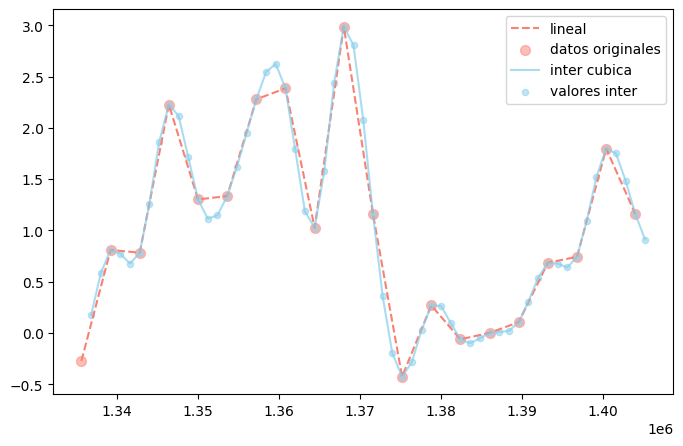

In [69]:
estacion = "2401500086"
dato = "vel u"
n = 3
first = 20

s , x = wsdata_dict[estacion]["segundos"] , wsdata_dict[estacion][dato]
s_nuevo , x_lineal , x_cubica = interpolacion(estacion, dato, n)

random_init = 200
random_init = np.random.random_integers(0, len(s) - first)

first_nuevo = n*(first - 1) + 1
random_init_nuevo = n*(random_init) + 1

plt.subplots(figsize=(8,5))
plt.plot(s[random_init:random_init + first] , x[random_init:random_init + first] , "--", color="salmon", label="lineal")
plt.scatter(s[random_init:random_init + first] , x[random_init:random_init + first] , color="salmon", label="datos originales", s=50, alpha=0.5)

plt.plot(s_nuevo[random_init_nuevo:random_init_nuevo + first_nuevo] , x_cubica[random_init_nuevo:random_init_nuevo + first_nuevo] , "-", color="skyblue", label="inter cubica", alpha=0.7)
plt.scatter(s_nuevo[random_init_nuevo:random_init_nuevo + first_nuevo] , x_cubica[random_init_nuevo:random_init_nuevo + first_nuevo] , color="skyblue", label="valores inter", alpha=0.5, s=20)

plt.legend()
plt.show()

In [70]:
n = 3
wsdata_inter = dict()
for estacion in estaciones_ok:
    wsdata_inter[estacion] = dict()
    for k in ["presion", "vel u", "vel v", "temperatura"]:
        s_nuevo , x_lineal , x_cubica = interpolacion(estacion, k, n)
        wsdata_inter[estacion][k] = x_cubica
        wsdata_inter[estacion]["segundos"] = s_nuevo
    for k in ["codigo_estacion", "latitud", "longitud", "altura"]:
        new_size = wsdata_inter[estacion]["segundos"].size
        wsdata_inter[estacion][k] = np.tile(wsdata_dict[estacion][k][0], new_size)

In [71]:
df_wsdata_inter = pd.concat([pd.DataFrame(wsdata_inter[estacion]) for estacion in estaciones_ok]).reset_index(drop=True)
df_wsdata_inter = df_wsdata_inter[[
    'codigo_estacion',
    'latitud',
    'longitud',
    'altura',
    'segundos',
    'presion',
    'vel u',
    'vel v',
    'temperatura',
       ]]
df_wsdata_inter.head()

,codigo_estacion,latitud,longitud,altura,segundos,presion,vel u,vel v,temperatura
0,0024015300,5.643,-73.518,2166.07,0.0,785.600000,0.394205,1.026938,15.000000
1,0024015300,5.643,-73.518,2166.07,1200.0,785.887417,0.135037,0.986103,14.303316
2,0024015300,5.643,-73.518,2166.07,2400.0,786.078822,0.116764,0.847622,13.904875
3,0024015300,5.643,-73.518,2166.07,3600.0,786.200000,0.250858,0.653506,13.700000
4,0024015300,5.643,-73.518,2166.07,4800.0,786.276733,0.448790,0.445768,13.584014


In [72]:
df_wsdata_inter.to_parquet("ws15_interpoladas.parquet", engine="fastparquet", index=False)

In [73]:
df_wsdata_inter["codigo_estacion"].nunique()

8